## **1. Blurring the background**

The following is done using an instance segmentation model (DeepLabV3). The DeepLabV3 architecture has *Resnet-101* as its architecture and is pretrained on the *image-net* dataset. The model returns the instance segmentation of the image. The image is then binarized keeping only the person class and the background is blurred using the mask obtained.

In [9]:
import cv2
from utils import *
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
from PIL import *
from instance_seg import get_prediction, random_colour_masks
import numpy as np
import os

Enter path of the image:  tests/cleavage.jpeg


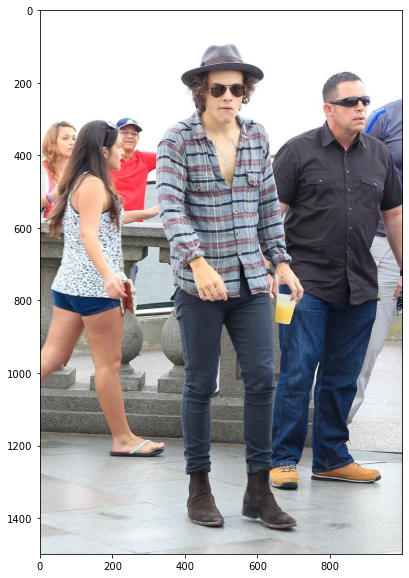

In [2]:
IMG_PATH = input('Enter path of the image: ')
img = cv2.imread(IMG_PATH)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

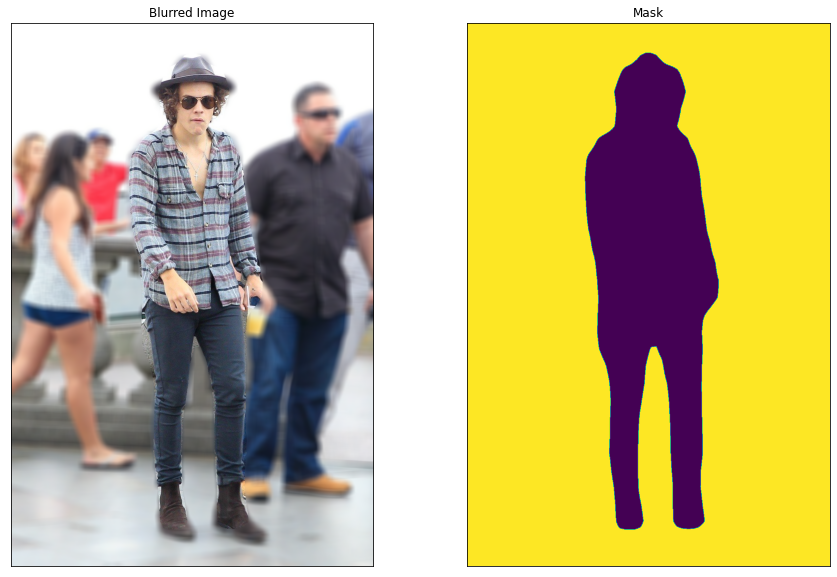

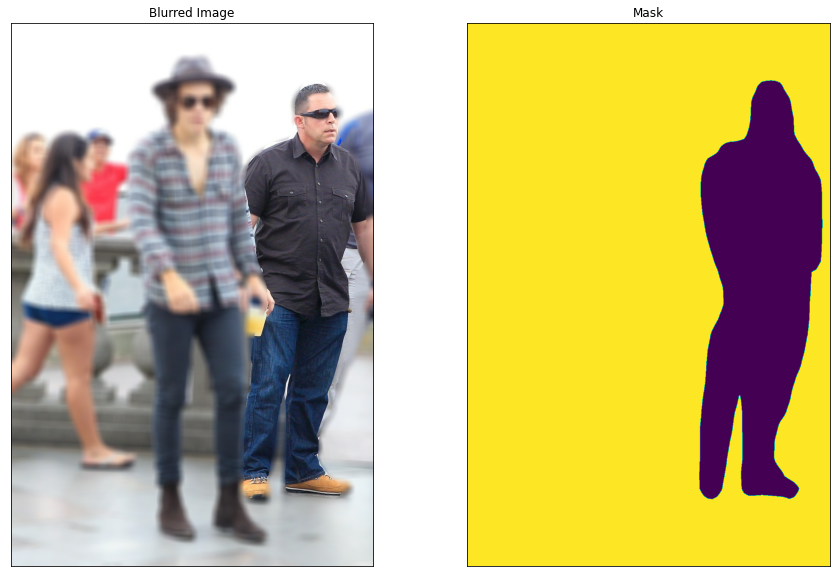

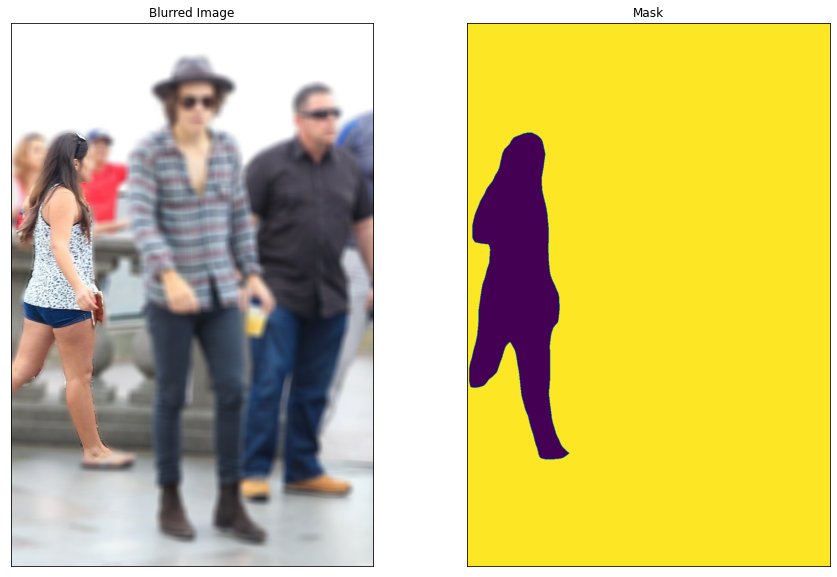

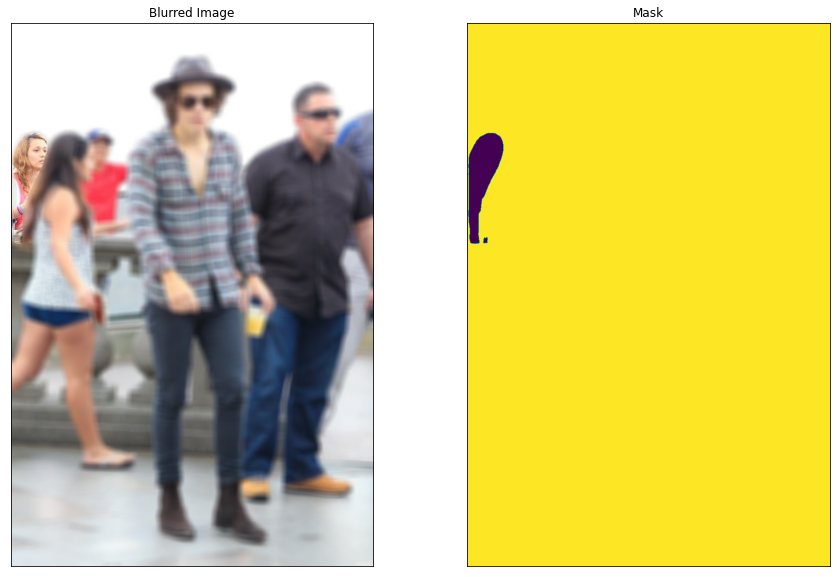

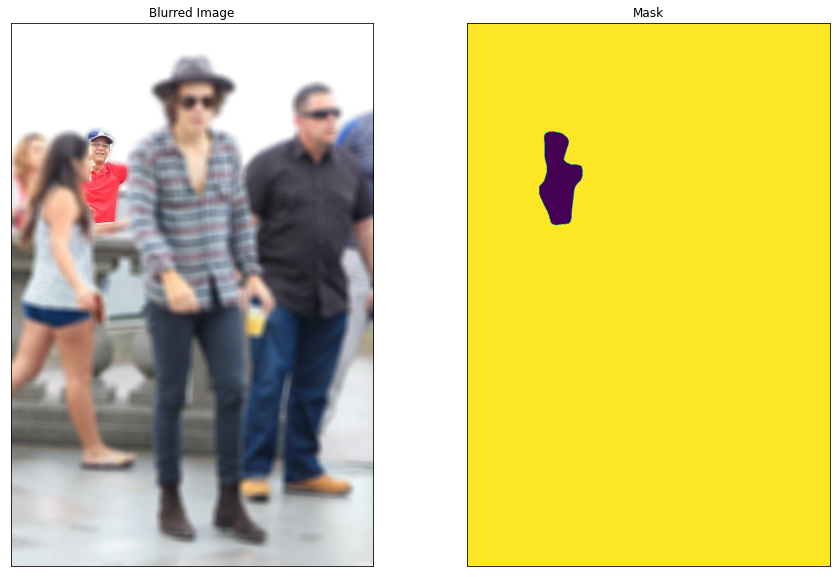

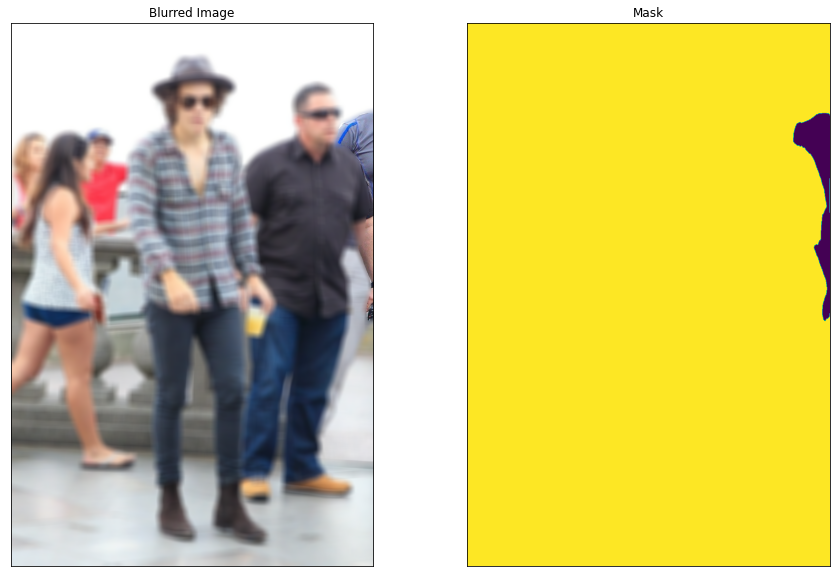

In [8]:
masks, bbox, preds = get_prediction(img, 0.85)
for i in range (len(masks)):
    mask = masks[i]!=1
    blur = cv2.blur(img,(21,21),0)
    out = img.copy()
    out[mask>0] = blur[mask>0]
    plot_blur_mask(out,mask)

## **2. Focus using Distance Transform**

In [6]:
# save the mask for future use
# save to npy file
np.save('harry1_mask.npy', mask)

In [11]:
def focus_with_distance(img, bw, name):
    try:
        os.mkdir('output3/'+name)
    except:
        pass
    cv2.imwrite("output3/"+name+"/focus3_before.jpeg",img)
    cv2.imwrite("output3/"+name+"/focus3_binary_map.jpeg",bw)
    dist = cv2.distanceTransform(bw, cv2.DIST_L2, 5)
    # Normalize the distance image for range = {0.0, 1.0}
    # so we can visualize and threshold it
    cv2.normalize(dist, dist, 0, 1, cv2.NORM_MINMAX)
    dist[dist < 0.01] =  0.005
    dist[(dist < 0.9) & (dist > 0.95) ] =  0.9
    dist[(dist < 1) & (dist > 0.95) ] =  0.95
    dist = -np.log(dist)
    cv2.normalize(dist, dist, 0, 1, cv2.NORM_MINMAX)
    cv2.imwrite("output3/"+name+"/focus3_distance.jpeg",dist*255)
    # applying the layers
    original_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(original_img)
    lim = 0
    #s[binary_mapping_img == 0] = 30
#     print("shapes of dist and s", dist.shape, s.shape)
    #s_new = cv2.multiply(s,1-dist, cv2.CV_8U)
    s_new = np.uint8(np.multiply(s, dist))
    v_new = np.uint8(np.multiply(v, dist))
    original_img = cv2.merge((h, s_new, v_new))
    original_img = cv2.cvtColor(original_img, cv2.COLOR_HSV2BGR)
    cv2.imwrite("output3/"+name+"/focus3.jpeg",original_img)
    
    return dist, original_img

In [14]:
# load the image
# img = cv2.imread('temp/harry1.jpeg')
# load the mask
# mask = np.load('harry1_mask.npy')
# dist, focus_img = focus_with_distance(img,mask,'harry1')
mask = masks[0]!=1
dist,focus_img = focus_with_distance(img,np.uint8(mask),'cleavage')

**Plotting the results obtained from the above cell**

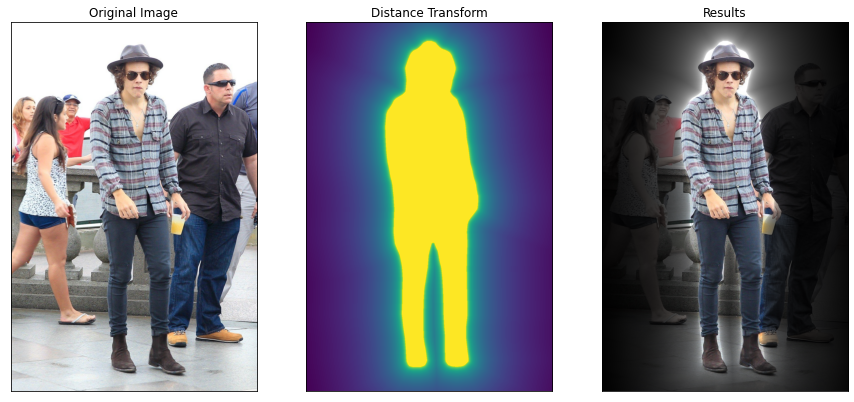

In [15]:
# subplot for original img
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.xticks([]);plt.yticks([])
plt.title('Original Image')

# sublot for distance transform
plt.subplot(1, 3, 2)
plt.imshow(dist)
plt.xticks([]);plt.yticks([])
plt.title('Distance Transform')

# sublot for final results
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(focus_img,cv2.COLOR_BGR2RGB))
plt.xticks([]);plt.yticks([])
plt.title('Results')

plt.show()

## **3. Clothing Detection**

Following categories can be identified:
bag
belt
boots
footwear
outer
dress
sunglasses
pants
top
shorts
skirt
headwear
scarf/tie

In [16]:
from yolo.utils.utils import *
from predictors.YOLOv3 import YOLOv3Predictor
import glob
from tqdm import tqdm
import sys

# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# DATASET
dataset = 'modanet'

# PARAMETERS
yolo_params =  {   
  "model_def" : "yolo/modanetcfg/yolov3-modanet.cfg",
  "weights_path" : "yolo/weights/yolov3-modanet_last.weights",
  "class_path":"yolo/modanetcfg/modanet.names",
  "conf_thres" : 0.5,
  "nms_thres" :0.4,
  "img_size" : 416,
  "device" : device
}

#Classes
classes = load_classes(yolo_params['class_path'])

#Colors
cmap = plt.get_cmap("rainbow")
colors = np.array([cmap(i) for i in np.linspace(0, 1, 13)])

# MODEL
model = 'yolo'
detectron = YOLOv3Predictor(params=yolo_params)


# read image_path
IMG_PATH, img_name = input_image()
OUT_PATH = input('Enter the path to the directory to save the file: ') 
img_blur = cv2.imread(IMG_PATH)

detections = detectron.get_detections(img_blur)
plot_clothing_detections(detections, img_blur, img_name, classes, colors, OUT_PATH)

Model loaded successfully from yolo/weights/yolov3-modanet_last.weights.


img path:  output3/cleavage/focus3.jpeg
Enter the path to the directory to save the file:  output3/cleavage


Saved successfully at output3/cleavage
	+ Label: headwear, Conf: 0.88266
	 (x1,y1,x2,y2) = (376, 87, 628, 217)
	+ Label: top, Conf: 0.92294
	 (x1,y1,x2,y2) = (314, 252, 709, 805)
	+ Label: pants, Conf: 0.94562
	 (x1,y1,x2,y2) = (359, 734, 668, 1281)
	+ Label: footwear, Conf: 0.97206
	 (x1,y1,x2,y2) = (394, 1268, 507, 1425)
	+ Label: sunglasses, Conf: 0.97710
	 (x1,y1,x2,y2) = (448, 196, 586, 242)
	+ Label: footwear, Conf: 0.97913
	 (x1,y1,x2,y2) = (550, 1265, 713, 1440)



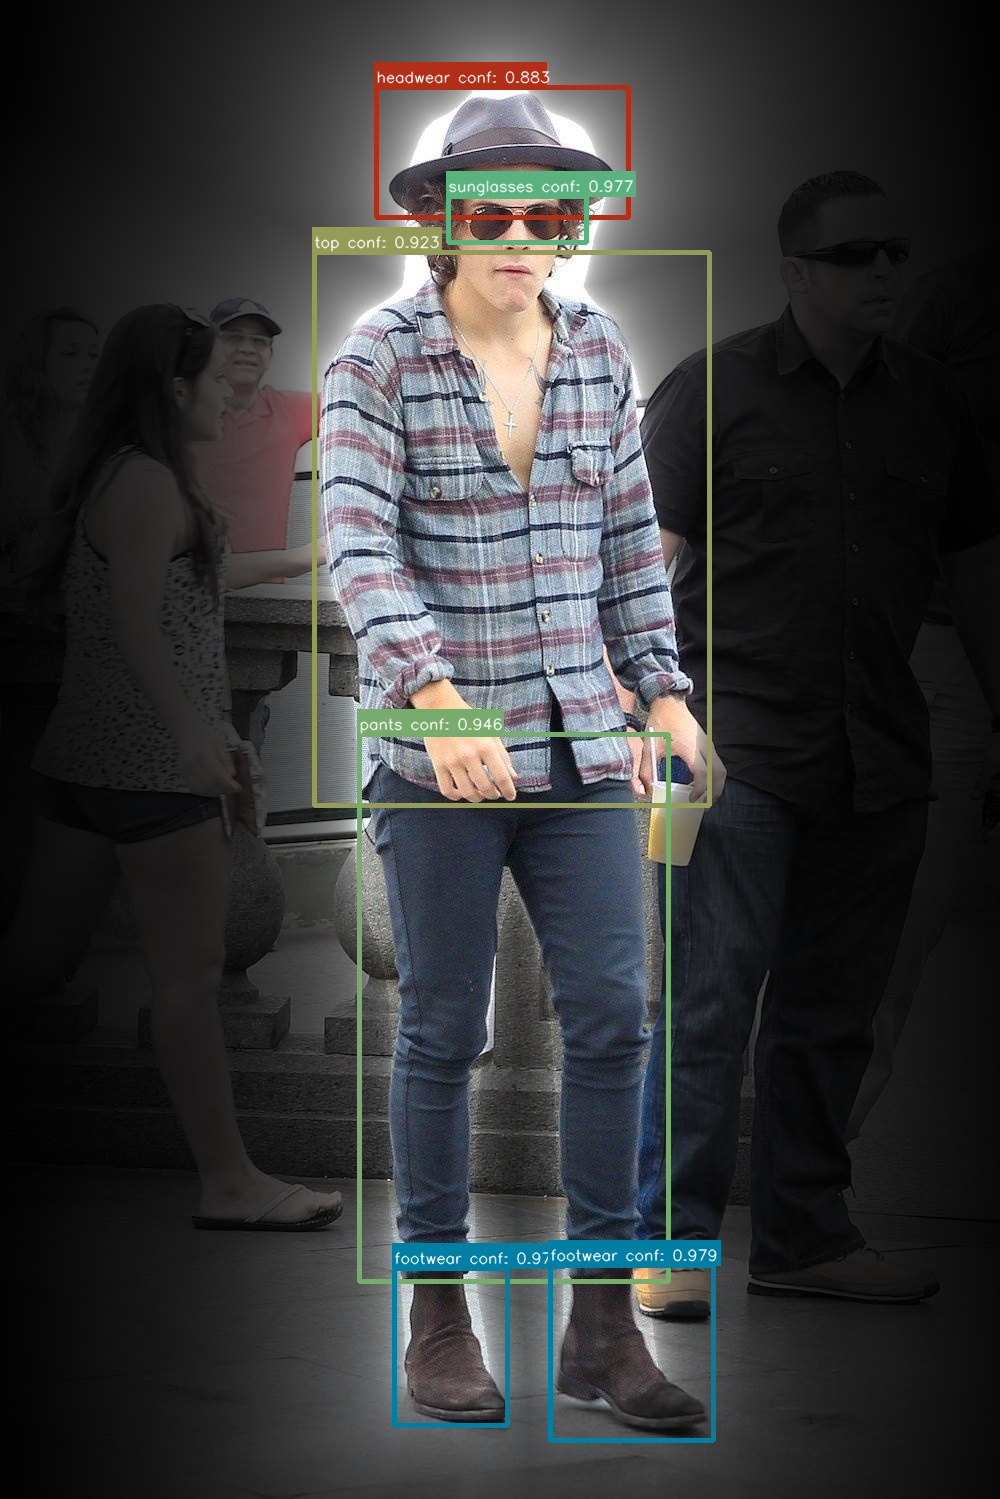

In [18]:
from PIL import *
Image.open('output3/cleavage/focus3.jpeg.png')

## **4. Resizing and cropping**

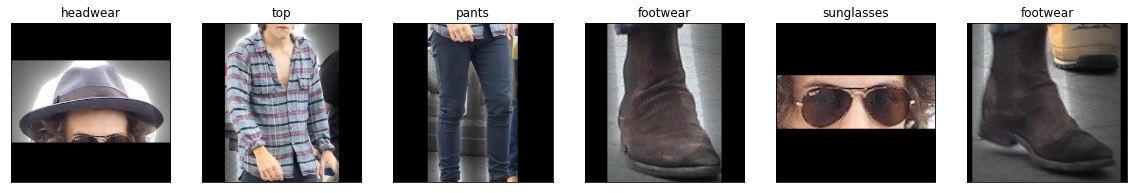

In [21]:
plt.rcParams["figure.figsize"] = (20,5)

def crop_garments(im_pth, detections):
    cat1 = [ 'outer', 'dress', 'pants', 'top', 'shorts', 'skirt']
    cat2 = ['bag', 'belt', 'boots','footwear','sunglasses','headwear', 'scarf/tie']
    
    n = len(detections)
    for i,(x1, y1, x2, y2, cls_conf, cls_pred) in enumerate(detections,1):
        
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        label = classes[int(cls_pred)]
        
        desired_size = 300 if label in cat1 else 150

        im = cv2.imread(im_pth)
        im = im[y1:y2,x1:x2]
        old_size = im.shape[:2] # old_size is in (height, width) format

        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        # new_size should be in (width, height) format

        im = cv2.resize(im, (new_size[1], new_size[0]))

        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)

        color = [0, 0, 0]
        new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)

        plt.subplot( 1,n, i)
        plt.imshow(cv2.cvtColor(new_im,cv2.COLOR_BGR2RGB))
        plt.xticks([]);plt.yticks([])
        plt.title(label)
    plt.show()
    
crop_garments('output3/cleavage/focus3.jpeg',detections)

In [49]:
# First create the image with alpha channel
rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)

# Then assign the mask to the last channel of the image
# mask = mask!=1
rgba[:, :, 3]==0 = np.uint8(mask)*255

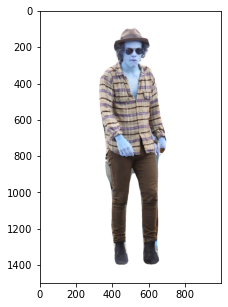

In [50]:
plt.imshow(rgba)
plt.show()

In [34]:
mask = mask!=1

In [46]:
np.unique(rgba[:,:,3])

array([255], dtype=uint8)

In [48]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])